In [18]:
### 4C16 Lab 5 - Convolutional Neural Nets for Image Classification.
# see handout-06
# https://frcs.github.io/4C16-LectureNotes/

In [ ]:
# Note: the training will run significantly faster if you run your notebook as a GPU instance.
# to change to GPU mode, you need to go in the colab menu to Runtime>Change runtime type
# then select "hardware accelerator" to GPU.
# This will restart your instance (obviously), so everytime you do this you'll need to
# start your again from the start of the notebook.

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-05/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/4c16-labs/code/lab-05


In [27]:
# Import the necessary modules

import tensorflow as tf

import keras
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import PReLU, LeakyReLU, Conv2D, MaxPool2D, Lambda
from keras.regularizers import l2

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [28]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();

def save_model_to_disk():
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to model.json and weights to model.h5")

In [29]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/cifar10-dataset.pkl https://tcddeeplearning.blob.core.windows.net/deeplearning202324/cifar10-dataset.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  7889k      0  0:00:19  0:00:19 --:--:-- 10.7M


loading the dataset...
loaded.
let's look at some of the pictures and their ground truth labels:


<ipython-input-30-419ef6b166b5>:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


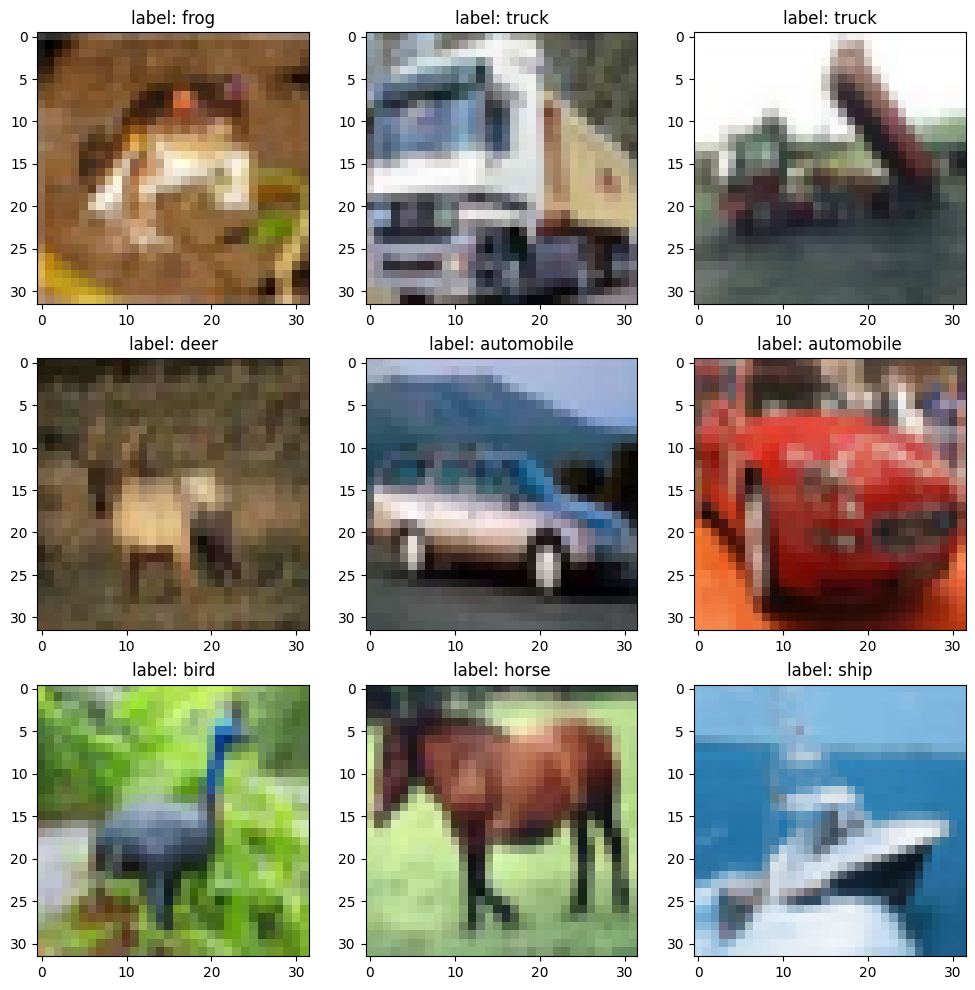

In [30]:
print('loading the dataset...')

pkl_file = open('/home/tcd/data/cifar10-dataset.pkl', 'rb')
dataset = pickle.load(pkl_file)

print('loaded.')

print('let\'s look at some of the pictures and their ground truth labels:')

plt.figure(figsize=(12,12))
plt.plot([3, 3])

X = dataset['X'].astype('float32')/255
Y = dataset['Y'].astype('float32')
Y = tf.keras.utils.to_categorical(Y)

for i in range(0,9):
    # pictures are 32x32x3 (width=32, height=32, 3 colour channels)
    pic = X[i]

    # Y[i] returns an array of zeros and with Y[i][classid] = 1
    # for instance  Y[i] = [ 0 0 0 0 0 1 0 0 0 0] => classid=5
    #          and  Y[i] = [ 1 0 0 0 0 0 0 0 0 0] => classid=0
    # we can get the classid by using the argmax function on the vector Y[i]
    classid = Y[i].argmax(-1)

    # getting back the name of the label for that classid
    classname = dataset['labels'][classid]
    plt.subplot(3,3,i+1)
    plt.imshow(pic)
    plt.title('label: {}'.format(classname))


In [31]:
# let's split data between validation set and training set

X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

In [36]:
# The model below contains 2 hidden layers with 64 nodes each.
# The activation functions for these 2 layers is the ReLU
# The network ends with a 10 nodes layer with softmax activation
# The first 2 hidden layers transform the original features into
# a new feature vector of size 64.
# The last layer essentially does the classification using multonomial regression
# based on these new features.

inputs = keras.layers.Input(shape=(32, 32, 3))


x = inputs  # Don't flatten until after your 2D layers

# put here some convolutional layers;
# see keras docs for Conv2D, MaxPool2D, etc.
# Maybe stick in some Dropout as well?
# Convolutional Layer 1:
x = Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.001))(x) # Capturing basic features
x = Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.001))(x) # Refining these features
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# Convolutional Layer 2:
x = Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.001))(x)
x = Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.001))(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# Convolutional Layer 3:
x = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.001))(x)
x = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.001))(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# The last layers of your model should look something like
# this to be well-structured for the final classification:
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
# Since Dense Layers are for learning high-level abstractions (from flattened features) - using 50% dropout to make a more general model
x = Dropout(0.5)(x)
# a few other dense layers? - Didn't find it necessary

predictions = Dense(10, activation='softmax')(x)  # There are 10 classes in this problem, hence the '10'.


# Create the model.
model = keras.models.Model(inputs=inputs, outputs=predictions)
# opt = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Using Adam as it leads to faster convergence
opt = keras.optimizers.Adam(learning_rate=0.001)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display a summary.
model.summary()

# Keep things sane.
if (model.count_params() > 4500000):
    raise Exception("Your model is unecessarily complex, scale down!")


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 128)       73856     
                                                           

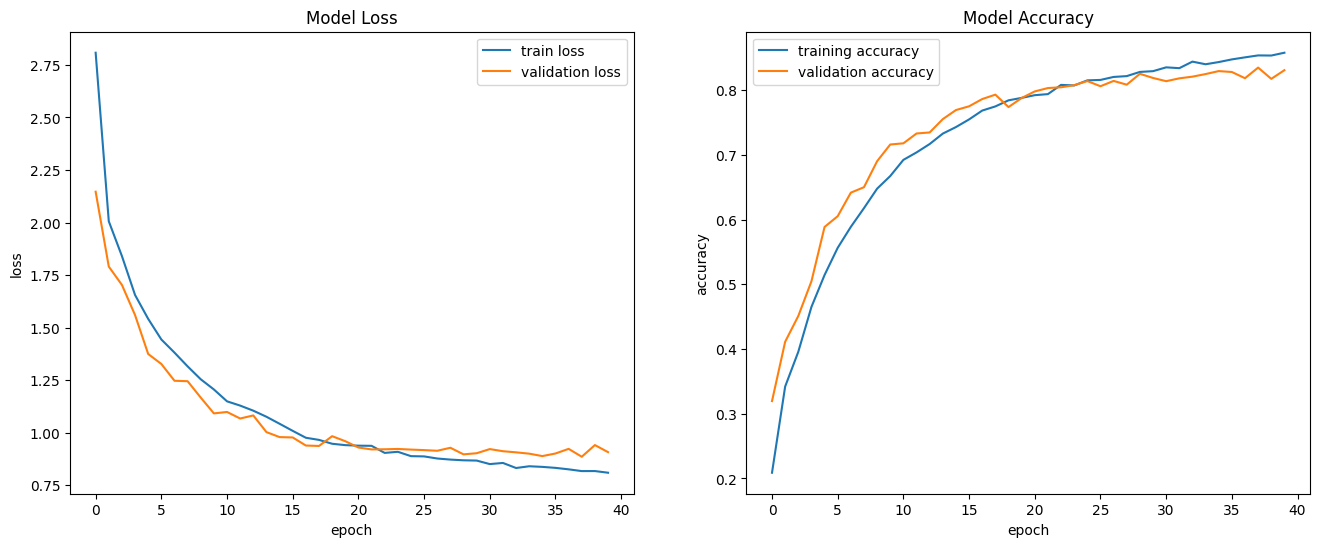

44/44 [==============================] - 12s 273ms/step - loss: 0.8101 - accuracy: 0.8578 - val_loss: 0.9081 - val_accuracy: 0.8308


In [37]:
# Note that you can evaluate this cell repeatedly to push the training of your model further.
# You might want to reduce the value of 'num_epochs' if each evaluation starts to take too long.

num_epochs = 40

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model.fit(X_train, Y_train,
          batch_size=1024, epochs=num_epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])


In [38]:
# write model to model.json and weights to model.h5 for submission

save_model_to_disk()

Saved model to model.json and weights to model.h5


In [39]:
# you can now commit and push and submit lab for assessment

In [40]:
# Question: using a combination of dense and convolutional layers, achieve 80%
#           or more accuracy on the server's test set.
#
# You may want try to:
#
#     add layers,
#     - change the number of filters per layer, (Increasing filters in each layer helps it to learn more diverse and sophisticated features)
#     - use stride and various pooling layers,(Used 2*2 max pooling to reduce spatial dimension by 2 - captures most important features while reducing complexity)
#     - check the effect of using valid or same padding.
#     valid decreases efficiency (on searching found out that valid padding leads to smaller output feature maps which makes it more difficult for image recog.)
#     ... and similarly to previous lab, you can always:
#     change the optimizer
#     the learning rate,
#     add Dropout [https://keras.io/layers/core/#dropout]
#     add Regularisers (eg. L2, L1) [https://keras.io/regularizers/]
#
# Good luck!
#
# F.A.Q.
#
#   I reached 81% on my validation set, but the submission didn't pass, how come?
#     > the test set on the server is different from your validation set
#
#   can I use convolutional layers?
#     > yes, that's the whole point of this lab
#